In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#style.use(('ggplot', 'seaborn-muted'))
style.use('seaborn-muted')
rc("image",cmap='gray',aspect='equal',interpolation='nearest')
rc("figure", figsize=(13,8))
#rc('font',family='ubuntu')
rc('axes', labelsize=16)
#from __future__ import division

In [3]:
from numba import jit

In [4]:
def load_stack_with_rescale(name, target_scale=0.2,verbose=False):
    if verbose:
        print(name)
    stack_, meta_ = ccdb.read_pic(name)
    dims_ = ccdb.get_axes(meta_)#[::-1]
    dx, dz = dims_[1][0], dims_[2][0]
    if verbose:
        print(dx,dz)
        print(dx/target_scale, dz/target_scale)
    stackz = ndi.zoom(stack_.astype(float),(dz/target_scale, dx/target_scale,dx/target_scale), order=1)
    return stackz

In [5]:
data_path = '/home/brazhe/yandex-disk/data-shared-comfi/3D-astrocyte-images/selected-for-complexity'

In [6]:
cd $data_path

/home/brazhe/yandex-disk/data-shared-comfi/3D-astrocyte-images/selected-for-complexity


In [7]:
sys.path.append('/home/brazhe/proj/semyanov-data/')

In [8]:
from tqdm.auto import tqdm

In [9]:
from importlib import reload

In [10]:
from astromorpho import io as aio
from astromorpho import enh, morpho

Can't load imreg package, affine and homography registrations won't work


/home/brazhe/proj/image-funcut/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/brazhe/proj/image-funcut/imfun/external/czifile.py:146: UserWarning: ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  warnings.warn(
/home/brazhe/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numba/core/decorators.py:150: NumbaDeprecationWarning: The 'target' keyword argument is deprecated.
  warnings.warn("The 'target' keyword argument is deprecated.", NumbaDeprecationWarning)


In [11]:
sys.path.append('/home/brazhe/proj/shearlexity/')

In [12]:
import shearlexity as shlx

/home/brazhe/src/PyShearlets/FFST/_fft.py:52: UserWarning: pyFFTW not found.  will try to use mklfft instead.
  warnings.warn("pyFFTW not found.  will try to use mklfft instead.")
/home/brazhe/src/PyShearlets/FFST/_fft.py:64: UserWarning: neither pyFFTW or mklfft found.  will use numpy.fft.
  warnings.warn("neither pyFFTW or mklfft found.  will use numpy.fft.")


In [13]:
from imfun.filt import cedf
from imfun.multiscale import atrous

In [14]:
from scipy import ndimage as ndi

In [15]:
import napari

In [16]:
import ccdb

In [17]:
names = !ls *.pic

In [18]:
names = [name for name in names if not 'hm' in name]
len(names)

89

In [29]:

k = randint(len(names))
#k = 18
#k = 48
#k = 63
#k = 81
#k = 70

name = names[k]
print(k, name)

zstack = load_stack_with_rescale(name)

68 4wk-ly15-raw.pic


In [30]:
%gui qt

In [31]:
zstack = zstack[:,10:-45,10:-45]

In [32]:
w = napari.view_image(zstack, ndisplay=3)

In [33]:
@jit
def probabilistic_sample(data, weights, Npoints=-1):
    sh = data.shape
    Npoints = len(data) if Npoints < 0 else Npoints
    done = False
    i = 0
    out = np.zeros((Npoints, sh[1]))
    while i < Npoints:
        for k in range(len(data)):
            point = data[k]
            if np.random.rand() < weights[k]:
                out[i] = point
                i+=1
                if i >= Npoints:
                    break
    return out

def percentile_rescale(arr, plow=1, phigh=99.5):
    low, high = np.percentile(arr, (plow, phigh))
    if low == high:
        return np.zeros_like(arr)
    else:
        return np.clip((arr-low)/(high-low), 0, 1)

In [34]:
import itertools as itt

In [35]:
%time X = np.array(list(itt.product(*map(range, zstack.shape)))) # N-dimensional, but slower

CPU times: user 2.75 s, sys: 235 ms, total: 2.99 s
Wall time: 2.97 s


In [36]:
from imfun.filt import l1spline, l2spline

In [37]:
gamma = 1
weights = percentile_rescale(np.ravel(zstack)**gamma)
weights_s = percentile_rescale(np.ravel(ndi.gaussian_filter(zstack,5))**2,plow=99.5,phigh=99.99)
#%time weights_s = percentile_rescale(np.ravel(l1spline(zstack,5))**2,plow=99,phigh=99.9)

In [38]:
center = np.sum(X*weights_s[:,None],axis=0)/np.sum(weights_s)
center

array([ 21.80324973, 214.57798183, 202.77284845])

In [39]:
Xc = X-center

In [40]:
import ucats

In [41]:
multiplicity=3

%time Xp = probabilistic_sample(Xc, weights, multiplicity*len(X))
%time u,s,vh = np.linalg.svd(Xp,full_matrices=False)
u,vh = ucats.decomposition.svd_flip_signs(u,vh, mode='u')
s /= np.sqrt(len(u)-1) # normalize by number of points

CPU times: user 10.1 s, sys: 109 ms, total: 10.2 s
Wall time: 10.2 s
CPU times: user 2.37 s, sys: 4.35 s, total: 6.72 s
Wall time: 2.15 s


In [42]:
vh

array([[-1.16628770e-04, -6.46067826e-01, -7.63279995e-01],
       [-1.36074553e-02, -7.63208306e-01,  6.46009225e-01],
       [ 9.99907407e-01, -1.04616417e-02,  8.70232702e-03]])

In [43]:
x = array([[(0,0,0), vh[0]]])
x.shape

(1, 2, 3)

In [44]:
x = np.array([[center,vh[k]*2*s[k]] for k in range(3)])
x

array([[[ 2.18032497e+01,  2.14577982e+02,  2.02772848e+02],
        [-1.80543367e-02, -1.00012425e+02, -1.18157073e+02]],

       [[ 2.18032497e+01,  2.14577982e+02,  2.02772848e+02],
        [-1.69553157e+00, -9.50981466e+01,  8.04947738e+01]],

       [[ 2.18032497e+01,  2.14577982e+02,  2.02772848e+02],
        [ 1.96146832e+01, -2.05220790e-01,  1.70709194e-01]]])

In [45]:
w = napari.view_image(zstack, ndisplay=3)
w.add_image(weights_s.reshape(zstack.shape), colormap='cyan',blending='additive')
w.add_vectors(x, edge_width=3, edge_color_cycle=['red','magenta', 'blue'])

<Vectors layer 'x' at 0x7ff1d1422a00>

In [46]:
Y = Xc@vh.T#@np.diag(1/s)

In [47]:
zstack_r = np.ravel(zstack)

In [48]:

Yx1 = Y[:,0][zstack_r > 17]
Yx2 = Y[:,1][zstack_r > 17]
Wx = zstack_r[zstack_r > 17]

In [49]:
xq = arange(-150,250, 5)

In [50]:
#bins1 = np.digitize(Yx1, xq,)

In [51]:
#yq = [np.mean(Wx[bins1==b]) for b in np.unique(bins1)]

In [52]:
#yq2 = [np.mean(Wx[(Yx >= b)*(Yx < b+5)]) for b in xq]

In [53]:
#xq2 = [np.mean(Yx[bins1==b]) for b in np.unique(bins1)]

In [54]:
#len(unique(bins1)), len(xq2)

Text(0.5, 1.0, 'Brightness distribution along first principal axis')

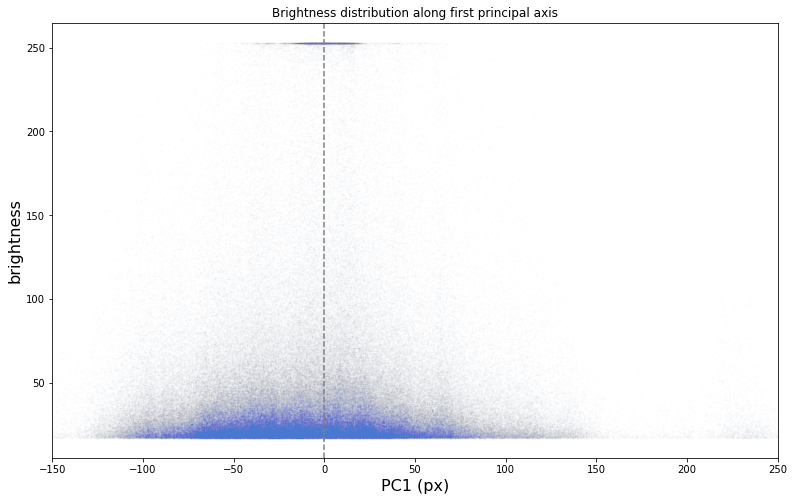

In [55]:
figure()
#plot(Y[:,0],np.ravel(zstack),'.', alpha=0.01)
#hexbin(Y[:,0][zstack_r>17],zstack_r[zstack_r>17],mincnt=5,cmap='plasma',bins='log')
plot(Yx1,Wx,'.',alpha=0.01,markersize=1.5)
xlim(-150,250)
ylabel('brightness')
xlabel('PC1 (px)')
axvline(0, color='gray',ls='--')

#plot(xq+2.5, yq2, lw=2)
#plot(xq2, yq, lw=2)

title('Brightness distribution along first principal axis')

#gcf()

Text(0.5, 1.0, 'Brightness distribution along second principal axis')

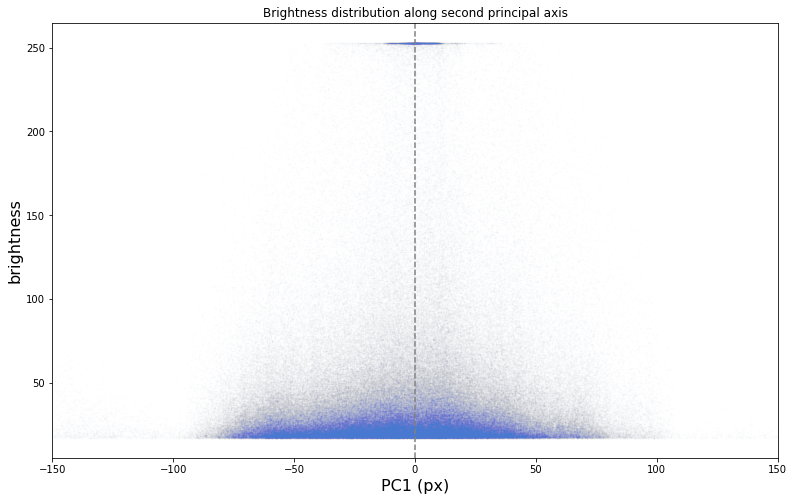

In [56]:
figure()
#plot(Y[:,0],np.ravel(zstack),'.', alpha=0.01)
#hexbin(Y[:,0][zstack_r>17],zstack_r[zstack_r>17],mincnt=5,cmap='plasma',bins='log')
plot(Y[:,1][zstack_r>17],zstack_r[zstack_r>17],'.',alpha=0.01,markersize=1.5)
xlim(-150,150)
ylabel('brightness')
xlabel('PC1 (px)')
axvline(0, color='gray',ls='--')
title('Brightness distribution along second principal axis')

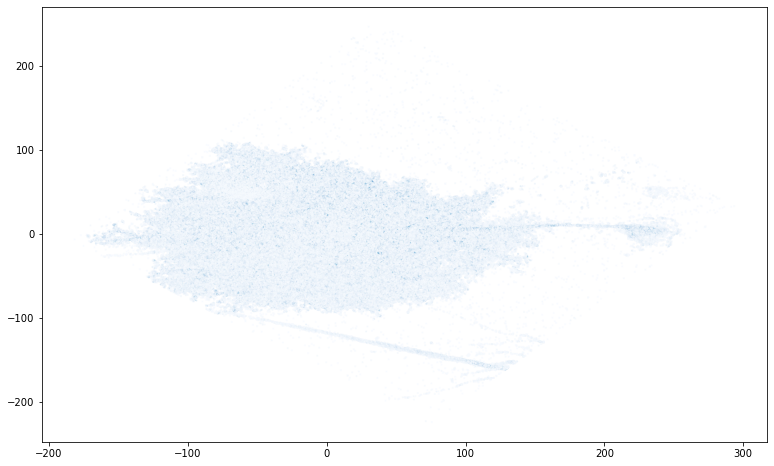

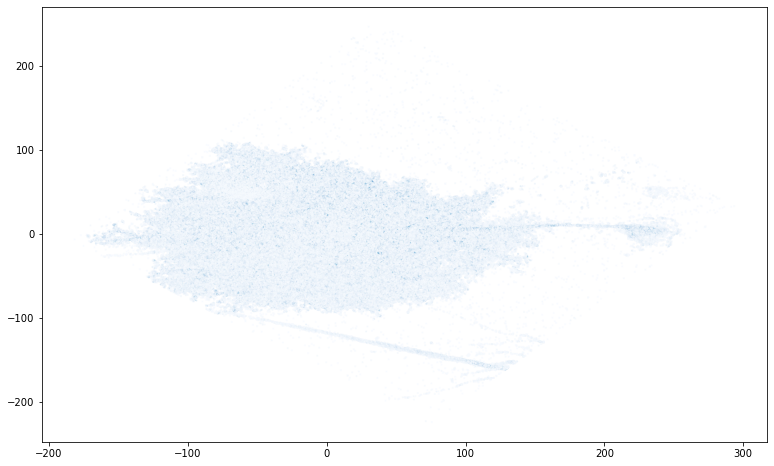

In [58]:
figure()
scatter(Y[:,0][zstack_r>17],Y[:,1][zstack_r>17],c=zstack_r[zstack_r>17],alpha=0.5, s=1, cmap=cm.Blues)

In [ ]:
s

In [ ]:
s[0]/s[1]

In [ ]:
np.min(Yx2), np.max(Yx2)

In [ ]:
(np.max(Yx)-np.min(Yx))/(np.max(Yx2) - np.min(Yx2))

In [ ]:
100 * np.sum(Wx[Yx > 0])/np.sum(Wx)

In [ ]:
100 * np.sum(Wx[Yx < 0])/np.sum(Wx)

In [ ]:
anisotropy = s[0]/np.sum(s[:2])
anisotropy

In [ ]:
close('all')

In [ ]:
s

In [ ]:
#w.add_vectors?